In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns


In [79]:


pd.set_option('display.max_columns', None)

df2 = pd.read_csv(r'C:\Users\Vipul\CreditLine-Decision-Engine-Using-Amazon-Sagemaker\credit.csv')

In [80]:
df2.head(2)

In [81]:
%%script false --no-raise-error
def preprocess(df):
    
    
    df = convert_to_lowercase(df)  
    df = handle_missing_values(df)                         
    df = extract_and_transform_features(df)                
    df = adjust_numeric_features(df)                       
    df = add_new_feature(df)                               
    df = drop_column(df)                                   
    
    # Add more preprocessing steps as needed

    return df

def convert_to_lowercase(df):
    return df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

def handle_missing_values(df):
    df['revol_util'].fillna(df['revol_util'].mean(), inplace=True)
    df['mort_acc'].fillna(0.0, inplace=True)
    df['home_ownership'].replace(['other', 'none', 'any'], np.nan, inplace=True)
    df.dropna(subset=['pub_rec_bankruptcies', 'home_ownership'], inplace=True)
    
    return df

def extract_and_transform_features(df):
    # Extract pincode if needed
    df['pincode'] = df['address'].str.extract(r'(\d{5})$')
    df['term'] = df['term'].astype(str).str.strip().map({'36 months': 3, '60 months': 5}).astype(int)
    df['annual_inc'] = np.ceil(df['annual_inc'] / 12)
    df['revol_bal'] = np.ceil(df['revol_bal'] * 0.05)
    
    return df

def adjust_numeric_features(df):
    df['pub_rec'] = df['pub_rec'].apply(lambda x: 0 if x < 1.0 else 1)
    df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].apply(lambda x: 0 if x == 0.0 else 1)
    df['mort_acc'] = df['mort_acc'].apply(lambda x: 1 if x > 0.0 else 0)
    df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'fully paid' else 0)
    df['verification_status'] = df['verification_status'].apply(lambda x: 1 if x in ['source verified', 'verified'] else 0)
    df['dti'] = df['dti'].apply(lambda x: x if x < 60 else 60)
    
    return df

def add_new_feature(df):
    bins = [0, 50, 75, float('inf')]
    bin_labels = ['0-50', '50-75', '75+']

    # Cut 'revol_util' values into bins
    df['revol_util_bins'] = pd.cut(df['revol_util'], bins=bins, labels=bin_labels, right=False)

    def calculate_pre_approved_offer(row):
        if row['loan_status'] == 1:
            if row['home_ownership'] in ['mortgage', 'own'] and row['grade'] in ['a', 'b'] and row['verification_status'] == 1 and row['pub_rec'] == 0 and row['mort_acc'] == 1 and row['pub_rec_bankruptcies'] == 0 and row['revol_util_bins'] in ['0-50', '50-75']:
                foir = 50
            elif row['home_ownership'] in ['mortgage', 'own', 'rent'] and row['grade'] in ['a', 'b', 'c', 'd'] and row['verification_status'] in [0, 1] and row['pub_rec'] == 0 and row['revol_util_bins'] in ['0-50', '50-75']:
                foir = 40
            elif row['home_ownership'] in ['mortgage', 'own', 'rent'] and row['grade'] in ['e', 'f', 'g'] and row['verification_status'] in [0, 1] and row['pub_rec'] == 0 and row['revol_util_bins'] in ['0-50', '50-75']:
                foir = 30
            else:
                return 'no'  # If none of the conditions are met, Pre-approved offer is 0

            new_emi = (row['annual_inc'] * (foir / 100)) - row['revol_bal'] - ((row['annual_inc'] * (row['dti'] / 100)) / 2)
            return 'yes' if new_emi > (row['installment'] * 1.25) else 'no'

        else:
            return 'no'

    # Apply the function to create the 'pre_approved_offer' column
    df['pre_approved_offer'] = df.apply(calculate_pre_approved_offer, axis=1)

    return df

def drop_column(df):

    """
    Drops unnecessary columns from the DataFrame.

    """

    df.drop(['revol_util','address','issue_d','purpose','title','earliest_cr_line','initial_list_status','int_rate','application_type','total_acc','emp_title','open_acc','emp_length','sub_grade'],axis = 1,inplace=True)

    return df


In [89]:
%%script false --no-raise-error
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming df is already defined and loaded with the data

# Split the data
df_train, temp = train_test_split(df, test_size=0.3)
df_validation, df_test = train_test_split(temp, test_size=0.5)

print("Shape of df_train before feature transformation:", df_train.shape)

# Define category arrays
grade_categories = [np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])]
revol_util_bins_categories = [np.array(['0-50', '50-75', '75+'])]
home_ownership_categories = [np.array(['own', 'mortgage', 'rent'])]

# Print shapes of category arrays
print("Grade categories shape:", grade_categories[0].shape)
print("Revol_util_bins categories shape:", revol_util_bins_categories[0].shape)
print("Home_ownership categories shape:", home_ownership_categories[0].shape)

# Define transformers
ordinal_grade_transformer = OrdinalEncoder(categories=grade_categories)
ordinal_revol_util_transformer = OrdinalEncoder(categories=revol_util_bins_categories)
ordinal_home_ownership_transformer = OrdinalEncoder(categories=home_ownership_categories)
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Create pipelines
numeric_transformer = make_pipeline(
    FunctionTransformer(np.log1p)
)

ordinal_transformers = Pipeline([
    ('ordinal_grade', ordinal_grade_transformer),
    ('ordinal_revol_util', ordinal_revol_util_transformer),
    ('ordinal_home_ownership', ordinal_home_ownership_transformer),
])

categorical_transformer = Pipeline([
    ('ordinal', ordinal_transformers),
    ('one_hot', one_hot_encoder),
])

# Create column transformer
feature_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, ['loan_amnt', 'installment', 'annual_inc', 'dti', 'revol_bal']),
        ('categorical', categorical_transformer, ['grade', 'revol_util_bins', 'home_ownership', 'pincode'])
    ],
    remainder='passthrough'
)

# Fit the feature transformer
X_train = feature_transformer.fit_transform(df_train)

# Now print the column names of the features being passed to the OrdinalEncoder transformers
print("\nColumn names for ordinal_grade:")
print(feature_transformer.transformers_[1][1].named_steps['ordinal'].named_steps['ordinal_grade'].categories_)

print("\nColumn names for ordinal_revol_util:")
print(feature_transformer.transformers_[1][1].named_steps['ordinal'].named_steps['ordinal_revol_util'].categories_)

print("\nColumn names for ordinal_home_ownership:")
print(feature_transformer.transformers_[1][1].named_steps['ordinal'].named_steps['ordinal_home_ownership'].categories_)


Couldn't find program: 'false'


In [66]:
df2['pre_approved_offer'].value_counts()

pre_approved_offer
no     232671
yes    162680
Name: count, dtype: int64

In [6]:
df2['grade'].value_counts()

grade
B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: count, dtype: int64

In [7]:
a = df2[df2['loan_status']!='Fully Paid']
a['sub_grade'].value_counts()

sub_grade
C4    4773
C3    4635
C5    4471
C2    4460
D1    4219
C1    4110
D2    3911
D4    3629
B4    3543
D3    3474
B5    3424
B3    3288
D5    3105
E2    2730
E1    2724
B2    2441
E3    2361
E4    2107
B1    1891
E5    1843
A5    1573
F1    1370
F2    1175
A4    1109
F3     997
F4     815
F5     680
A3     614
G1     488
A2     461
G2     364
G3     282
A1     279
G4     168
G5     159
Name: count, dtype: int64

We will drop this sub_grade column as well. For eg. I was hoping that values with grade with B5 and D5 would have a lot of difference but that is not the case. We will drop it.

In [8]:
# Drop the specified columns
df = df2.drop(['issue_d','purpose','title','earliest_cr_line','initial_list_status','int_rate','application_type','total_acc','emp_title','open_acc','emp_length','sub_grade'], axis=1)

# Reset index without adding a default index
df.reset_index(drop=True, inplace=True)


In [9]:
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [10]:
df.head(5)

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,329.48,b,rent,117000.0,not verified,fully paid,26.24,0.0,36369.0,41.8,0.0,0.0,"0174 michelle gateway\r\nmendozaberg, ok 22690"
1,8000.0,36 months,265.68,b,mortgage,65000.0,not verified,fully paid,22.05,0.0,20131.0,53.3,3.0,0.0,"1076 carney fort apt. 347\r\nloganmouth, sd 05113"
2,15600.0,36 months,506.97,b,rent,43057.0,source verified,fully paid,12.79,0.0,11987.0,92.2,0.0,0.0,"87025 mark dale apt. 269\r\nnew sabrina, wv 05113"
3,7200.0,36 months,220.65,a,rent,54000.0,not verified,fully paid,2.60,0.0,5472.0,21.5,0.0,0.0,"823 reid ford\r\ndelacruzside, ma 00813"
4,24375.0,60 months,609.33,c,mortgage,55000.0,verified,charged off,33.95,0.0,24584.0,69.8,1.0,0.0,"679 luna roads\r\ngreggshire, va 11650"


In [11]:
df.shape

(396030, 15)

In [12]:
df['pincode'] = df['address'].str.extract(r'(\d{5})$')
df.drop('address',axis=1,inplace=True)

In [13]:
df.head(1)

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,pincode
0,10000.0,36 months,329.48,b,rent,117000.0,not verified,fully paid,26.24,0.0,36369.0,41.8,0.0,0.0,22690


In [14]:
df['loan_amnt'].max()

40000.0

In [15]:
df['dti'].max()

9999.0

There is some problem with the dti column. It cannot be greater than 100. I mean it can be but anything above 100 does not matter. We will work on this on later stage.

In [16]:
df.value_counts('home_ownership')

home_ownership
mortgage    198348
rent        159790
own          37746
other          112
none            31
any              3
Name: count, dtype: int64

In [17]:
df.value_counts('pincode')

pincode
70466    56985
30723    56546
22690    56527
48052    55917
00813    45824
29597    45471
05113    45402
11650    11226
93700    11151
86630    10981
Name: count, dtype: int64

In [18]:
df.value_counts('pub_rec')

pub_rec
0.0     338272
1.0      49739
2.0       5476
3.0       1521
4.0        527
5.0        237
6.0        122
7.0         56
8.0         34
9.0         12
10.0        11
11.0         8
12.0         4
13.0         4
19.0         2
15.0         1
17.0         1
24.0         1
40.0         1
86.0         1
Name: count, dtype: int64

In [19]:

df.value_counts('mort_acc')

mort_acc
0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
26.0         2
31.0         2
32.0         2
28.0         1
30.0         1
34.0         1
Name: count, dtype: int64

In [20]:
df.value_counts('pub_rec_bankruptcies')


pub_rec_bankruptcies
0.0    350380
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: count, dtype: int64

Dropping this 'total_acc' column as well as it will not adding any additional value to the model. There are some discrepancies as well. Someone with less than 1 year of experience is having 26 accounts, which is not possible.

Even if someone has completed 1 loan from Loan Tap successfully, he should be eligible for another loan.

In [21]:
df.shape 

(396030, 15)

In [22]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   installment           396030 non-null  float64
 3   grade                 396030 non-null  object 
 4   home_ownership        396030 non-null  object 
 5   annual_inc            396030 non-null  float64
 6   verification_status   396030 non-null  object 
 7   loan_status           396030 non-null  object 
 8   dti                   396030 non-null  float64
 9   pub_rec               396030 non-null  float64
 10  revol_bal             396030 non-null  float64
 11  revol_util            395754 non-null  float64
 12  mort_acc              358235 non-null  float64
 13  pub_rec_bankruptcies  395495 non-null  float64
 14  pincode               396030 non-null  object 
dtype

In [23]:
df.isnull().sum()

loan_amnt                   0
term                        0
installment                 0
grade                       0
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
dti                         0
pub_rec                     0
revol_bal                   0
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      535
pincode                     0
dtype: int64

In [24]:
categorical_column = []
nemrical_column = []

for i in df.columns:
    if df[i].dtype == 'object':
        categorical_column.append(i)
    else:
        nemrical_column.append(i)

In [25]:
# Number of unique values in all non-numeric columns
for col in categorical_column:
  print(f"No. of unique values in {col}: {df[col].nunique()}")

No. of unique values in term: 2
No. of unique values in grade: 7
No. of unique values in home_ownership: 6
No. of unique values in verification_status: 3
No. of unique values in loan_status: 2
No. of unique values in pincode: 10


## Data Engineering

In [26]:
df.head(3)

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,pincode
0,10000.0,36 months,329.48,b,rent,117000.0,not verified,fully paid,26.24,0.0,36369.0,41.8,0.0,0.0,22690
1,8000.0,36 months,265.68,b,mortgage,65000.0,not verified,fully paid,22.05,0.0,20131.0,53.3,3.0,0.0,05113
2,15600.0,36 months,506.97,b,rent,43057.0,source verified,fully paid,12.79,0.0,11987.0,92.2,0.0,0.0,05113


### Data Engineering on Categorical columns

In [27]:
#converting months into years.
df['term'] = df['term'].astype(str)
df['term'] = df['term'].str.strip().map({'36 months': 3, '60 months': 5}).astype(int)



In [28]:
# DROPPING rows that contain home_ownership as OTHER', 'NONE', 'ANY. We cannot risk giving loan to someone we dont know where they are living.

# Replace 'OTHER', 'NONE', and 'ANY' with NaN in the 'home_ownership' column
df['home_ownership'].replace(['other', 'none', 'any'], np.nan, inplace=True)

# Drop rows with NaN in the 'home_ownership' column
df.dropna(subset=['home_ownership'], inplace=True)


In [29]:
df['home_ownership'].value_counts()

home_ownership
mortgage    198348
rent        159790
own          37746
Name: count, dtype: int64

In [30]:
#converting  annual income to monthly as we will be calculating eligiblity on monthly basis
df['annual_inc'] = np.ceil(df['annual_inc'] / 12)

In [31]:
# converting revol_bal to monthly liable value. Generally it is 5% of total outstanding amount.

df['revol_bal'] = np.ceil(df['revol_bal']*0.05)

In [32]:
df.head(3)

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,pincode
0,10000.0,3,329.48,b,rent,9750.0,not verified,fully paid,26.24,0.0,1819.0,41.8,0.0,0.0,22690
1,8000.0,3,265.68,b,mortgage,5417.0,not verified,fully paid,22.05,0.0,1007.0,53.3,3.0,0.0,05113
2,15600.0,3,506.97,b,rent,3589.0,source verified,fully paid,12.79,0.0,600.0,92.2,0.0,0.0,05113


### Working on missing values

In [33]:
missing_values = df.isna().sum()
print(missing_values)

loan_amnt                   0
term                        0
installment                 0
grade                       0
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
dti                         0
pub_rec                     0
revol_bal                   0
revol_util                274
mort_acc                37715
pub_rec_bankruptcies      533
pincode                     0
dtype: int64


In [34]:
# Fill 'revol_util' column with average. Since we can assume that they are having average used revolving credit. It is conservative.
df['revol_util'].fillna(df['revol_util'].mean(), inplace=True)

# Fill 'mort_acc' column with 0.0. 
# Ones with having no value for mortgage, we will consider as 0. We will try to be as conservative as possible.
df['mort_acc'].fillna(0.0, inplace=True)

# Drop rows with missing values in 'pub_rec_bankruptcies' column.
# we cannot take any chances since we dont have data for bankruptcies. we will simply drop these rows.
df.dropna(subset=['pub_rec_bankruptcies'], inplace=True)

In [35]:
df.isna().sum().sum()

0

We have worked on all the missing values.

### Working on numerical columns

In [36]:
df.head(3)

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,pincode
0,10000.0,3,329.48,b,rent,9750.0,not verified,fully paid,26.24,0.0,1819.0,41.8,0.0,0.0,22690
1,8000.0,3,265.68,b,mortgage,5417.0,not verified,fully paid,22.05,0.0,1007.0,53.3,3.0,0.0,05113
2,15600.0,3,506.97,b,rent,3589.0,source verified,fully paid,12.79,0.0,600.0,92.2,0.0,0.0,05113


In [37]:
df.dtypes

loan_amnt               float64
term                      int32
installment             float64
grade                    object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
dti                     float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
mort_acc                float64
pub_rec_bankruptcies    float64
pincode                  object
dtype: object

In [38]:
df['pub_rec'] = df['pub_rec'].apply(lambda x: 0 if x < 1.0 else 1)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].apply(lambda x: 0 if x == 0.0 else 1)
df['mort_acc'] = df['mort_acc'].apply(lambda x: 1 if x > 0.0 else 0)
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'fully paid' else 0)
df['verification_status'] = df['verification_status'].apply(lambda x: 1 if x in ['source verified', 'verified'] else 0)



In [39]:
df['dti'] = df['dti'].apply(lambda x: x if x < 60 else 60)

In [40]:
df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0    350237
1     45114
Name: count, dtype: int64

In [41]:
df['pub_rec'].value_counts()

pub_rec
0    337613
1     57738
Name: count, dtype: int64

In [42]:
df['mort_acc'].value_counts()

mort_acc
1    218416
0    176935
Name: count, dtype: int64

In [43]:
df.head(3)

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,pincode
0,10000.0,3,329.48,b,rent,9750.0,0,1,26.24,0,1819.0,41.8,0,0,22690
1,8000.0,3,265.68,b,mortgage,5417.0,0,1,22.05,0,1007.0,53.3,1,0,05113
2,15600.0,3,506.97,b,rent,3589.0,1,1,12.79,0,600.0,92.2,0,0,05113


In [44]:
df.shape

(395351, 15)

### Feature Creation

We will be creating 2 features :-

    Binning revol_util into bins and then dropping it.

    We will be creating target column as 'Pre-approved offer' as Yes or NO.





In [45]:
# Adding revol_util_bins as new feature.

bins = [0, 50, 75, float('inf')]

# DefinING bin labels
bin_labels = ['0-50', '50-75', '75+']

# Cut 'revol_util' values into bins
df['revol_util_bins'] = pd.cut(df['revol_util'], bins=bins, labels=bin_labels, right=False)


In [46]:
df.head(5)

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,pincode,revol_util_bins
0,10000.0,3,329.48,b,rent,9750.0,0,1,26.24,0,1819.0,41.8,0,0,22690,0-50
1,8000.0,3,265.68,b,mortgage,5417.0,0,1,22.05,0,1007.0,53.3,1,0,05113,50-75
2,15600.0,3,506.97,b,rent,3589.0,1,1,12.79,0,600.0,92.2,0,0,05113,75+
3,7200.0,3,220.65,a,rent,4500.0,0,1,2.60,0,274.0,21.5,0,0,00813,0-50
4,24375.0,5,609.33,c,mortgage,4584.0,1,0,33.95,0,1230.0,69.8,1,0,11650,50-75


In [47]:
df['grade'].value_counts()

grade
b    115809
c    105818
a     64046
d     63418
e     31457
f     11753
g      3050
Name: count, dtype: int64

Now we will add our target feature 'pre-approved offer' based on domain knowledge. It involves some calculations.

In [48]:
def calculate_pre_approved_offer(row):
    if row['loan_status'] == 1:
        if  row['home_ownership'] in ['mortgage' , 'own' ] and row['grade'] in ['a', 'b'] and row['verification_status'] == 1 and row['pub_rec'] == 0 and row['mort_acc'] == 1 and row['pub_rec_bankruptcies'] == 0 and row['revol_util_bins'] in ['0-50', '50-75']:
            foir = 50
        elif row['home_ownership'] in ['mortgage' , 'own' , 'rent' ] and row['grade'] in ['a', 'b', 'c', 'd'] and row['verification_status'] in [0,1] and row['pub_rec'] == 0 and row['revol_util_bins'] in ['0-50', '50-75']:
            foir = 40
        elif row['home_ownership'] in ['mortgage' , 'own' , 'rent' ] and row['grade'] in ['e', 'f', 'g'] and row['verification_status'] in [0,1] and row['pub_rec'] == 0 and row['revol_util_bins'] in ['0-50', '50-75']:
            foir = 30
        else:
            return 0  # If none of the conditions are met, Pre-approved offer is 0

        new_emi = (row['annual_inc'] * (foir / 100)) - row['revol_bal'] - ((row['annual_inc'] * (row['dti'] / 100)) / 2)
        return 1 if new_emi > (row['installment'] * 1.25) else 0
    elif row['loan_status'] == 0:
        return 0
    else:
        return 0

# Apply the function to create the 'Pre-approved offer' column
df['pre-approved offer'] = df.apply(calculate_pre_approved_offer, axis=1)

In [49]:
# dropping revol_util column as we dont need it anymore for our model.

df.drop('revol_util',inplace=True,axis=1)
df.reset_index(drop=True, inplace=True)


In [50]:
df.head(5)

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,mort_acc,pub_rec_bankruptcies,pincode,revol_util_bins,pre-approved offer
0,10000.0,3,329.48,b,rent,9750.0,0,1,26.24,0,1819.0,0,0,22690,0-50,1
1,8000.0,3,265.68,b,mortgage,5417.0,0,1,22.05,0,1007.0,1,0,05113,50-75,1
2,15600.0,3,506.97,b,rent,3589.0,1,1,12.79,0,600.0,0,0,05113,75+,0
3,7200.0,3,220.65,a,rent,4500.0,0,1,2.60,0,274.0,0,0,00813,0-50,1
4,24375.0,5,609.33,c,mortgage,4584.0,1,0,33.95,0,1230.0,1,0,11650,50-75,0


In [51]:
df['pre-approved offer'].value_counts()

pre-approved offer
0    232671
1    162680
Name: count, dtype: int64

### Data Visualization

Lets see what relation pincode is having with Loan_status

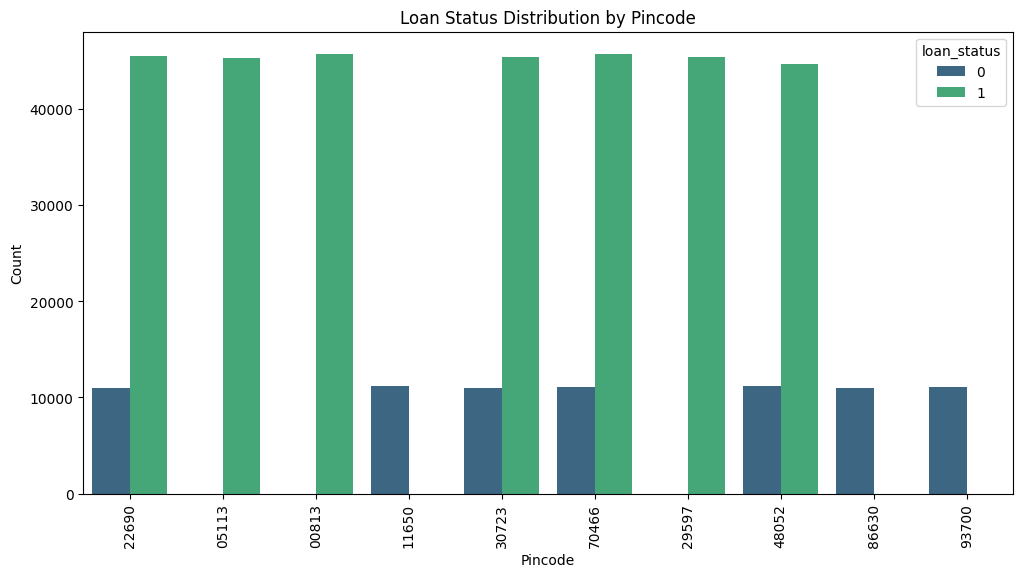

In [52]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='pincode', hue='loan_status', palette='viridis')
plt.xticks(rotation=90)
plt.title('Loan Status Distribution by Pincode')
plt.xlabel('Pincode')
plt.ylabel('Count')
plt.show()

Interesting, All the loan from the Pin code 93700,11650,86630 have been defaulter. If we want to fund people from these areas we will have to be very cautious. We will only offer pre-approved loans to the people who have been a top profile.

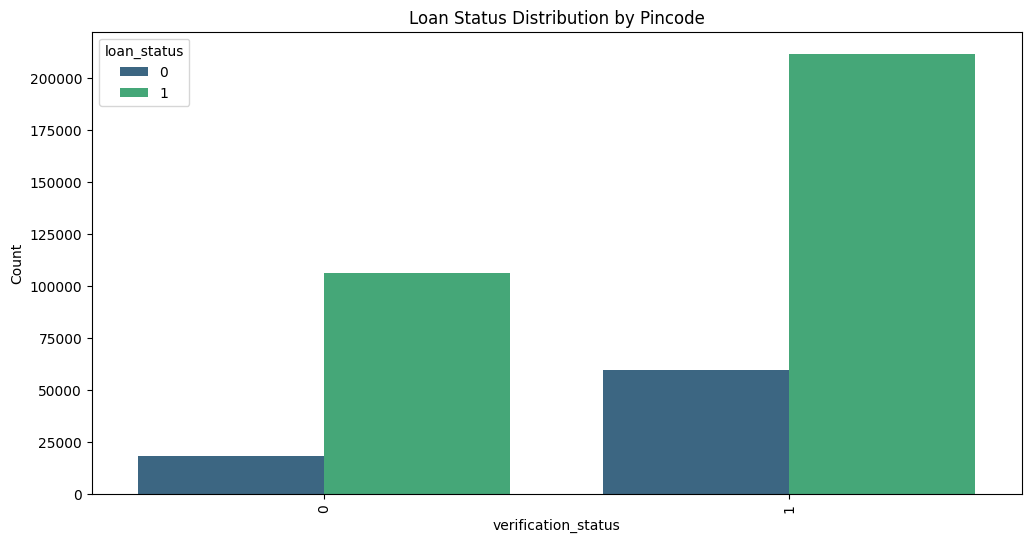

In [53]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='verification_status' ,hue='loan_status', palette='viridis')
plt.xticks(rotation=90)
plt.title('Loan Status Distribution by Pincode')
plt.xlabel('verification_status')
plt.ylabel('Count')
plt.show()

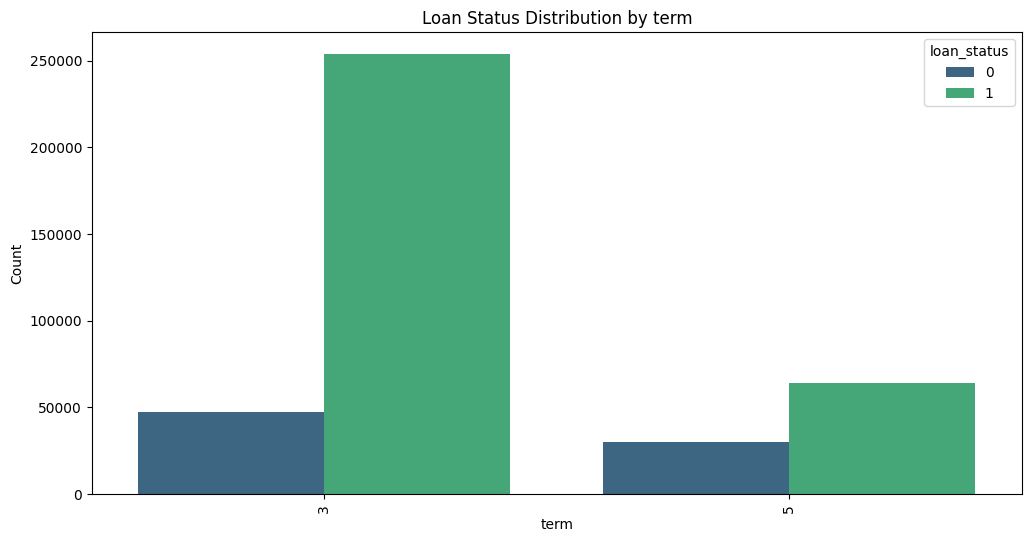

In [54]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='term', hue='loan_status', palette='viridis')
plt.xticks(rotation=90)
plt.title('Loan Status Distribution by term')
plt.xlabel('term')
plt.ylabel('Count')
plt.show()

We have a nice observation here, 20% of the total loan that were borrowed for 3 years defaulted on their payments.
Where as almost 50% of the total loan that were borrowed for 5 years defaulted on their payments.

We can conclude that the term of the loan has a significant impact on the loan status.
We will be only offering 3 years as max tenure. 5 years will only be offered if the profile is top 10% of all the clients.
Someone has to tick every box to be able to borrow the loan for 5 years.

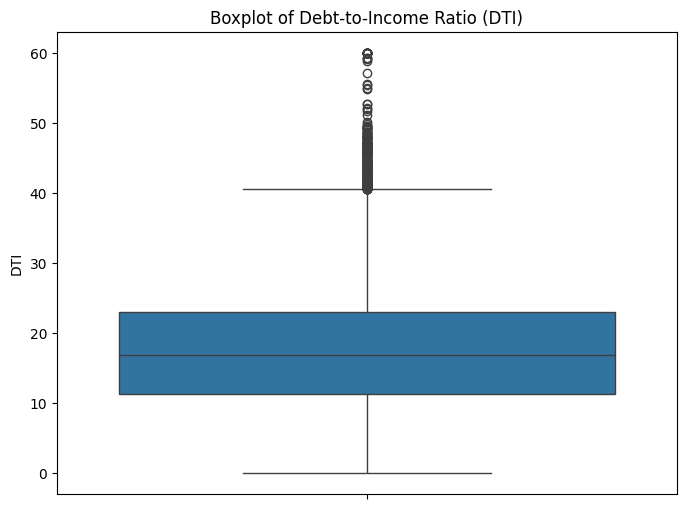

In [55]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='dti')
plt.title('Boxplot of Debt-to-Income Ratio (DTI)')
plt.ylabel('DTI')
plt.show()

We will not be removing these outlier in dti as these values are crucial for the model.

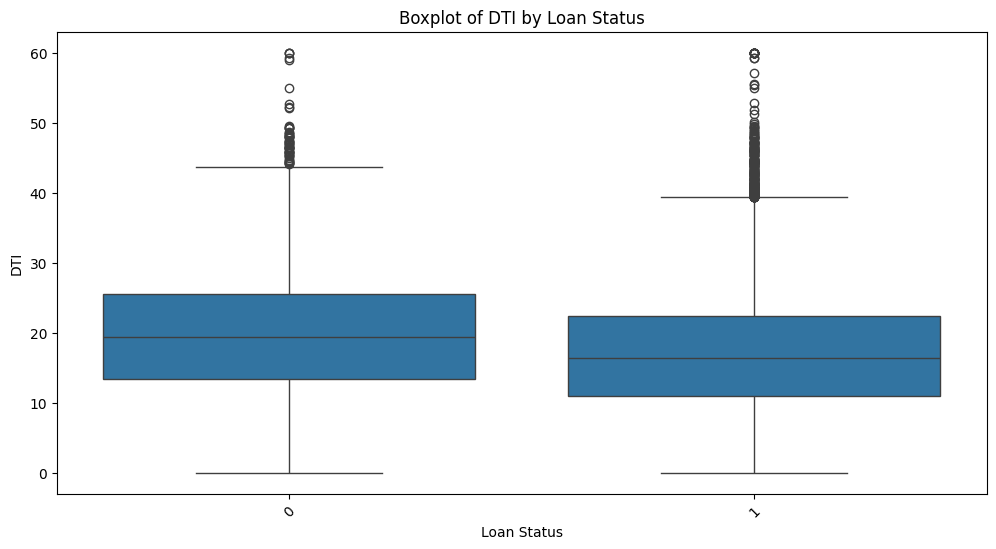

In [56]:
# Plotting a boxplot of 'dti' by 'loan_status'
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='dti', data=df)
plt.title('Boxplot of DTI by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('DTI')
plt.xticks(rotation=45)
plt.show()


In [57]:
categorical_column = []
neumrical_column = []

for i in df.columns:
    if df[i].dtype == 'object':
        categorical_column.append(i)
    else:
        neumrical_column.append(i)

neumrical_column

['loan_amnt',
 'term',
 'installment',
 'annual_inc',
 'verification_status',
 'loan_status',
 'dti',
 'pub_rec',
 'revol_bal',
 'mort_acc',
 'pub_rec_bankruptcies',
 'revol_util_bins',
 'pre-approved offer']

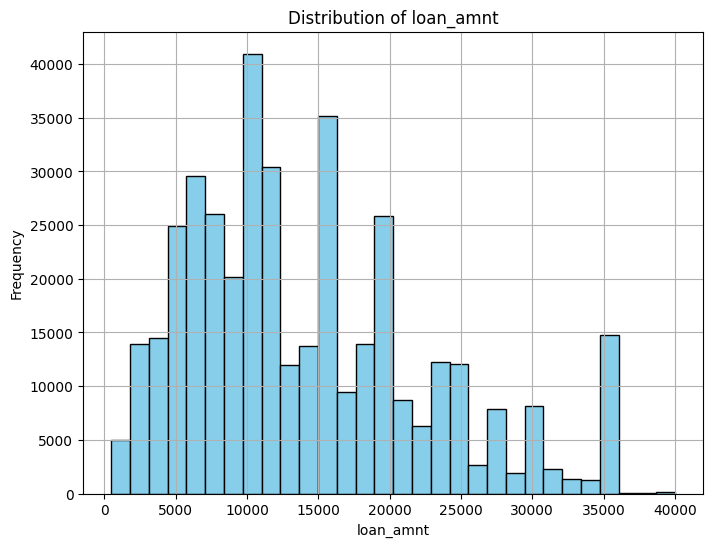

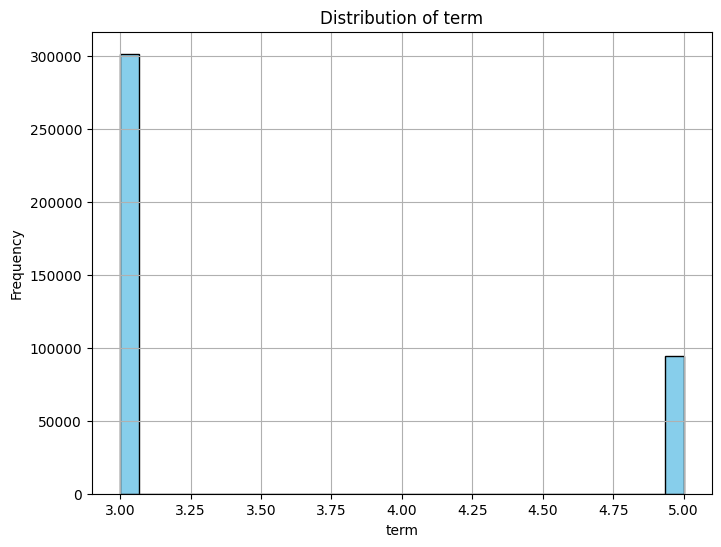

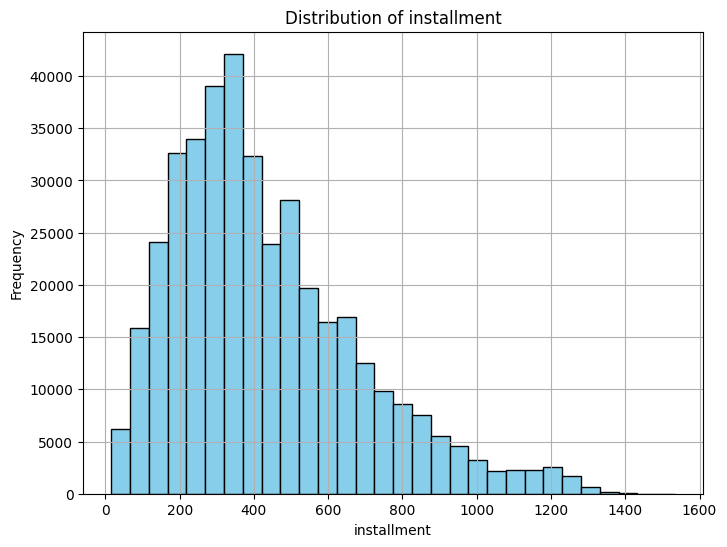

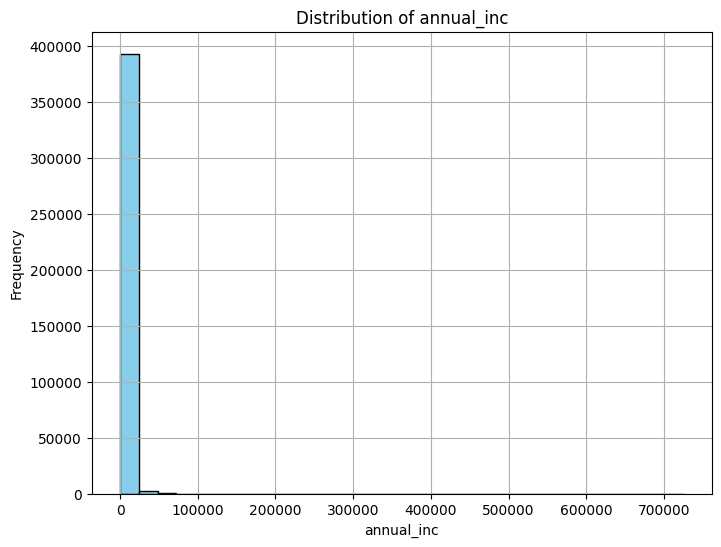

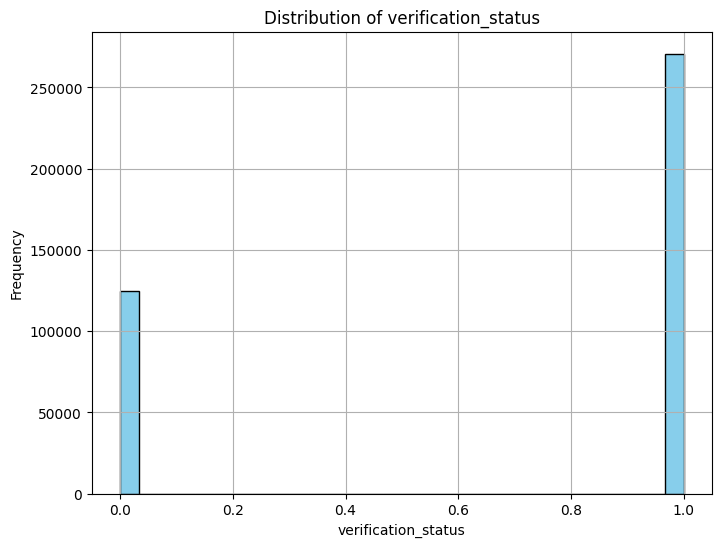

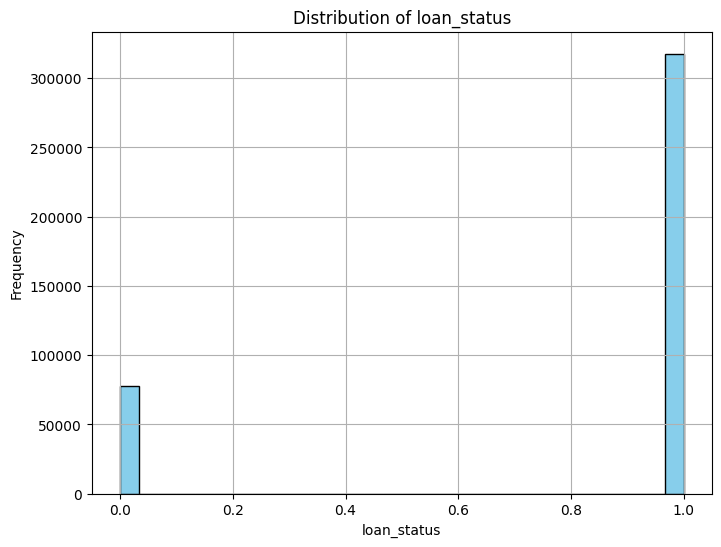

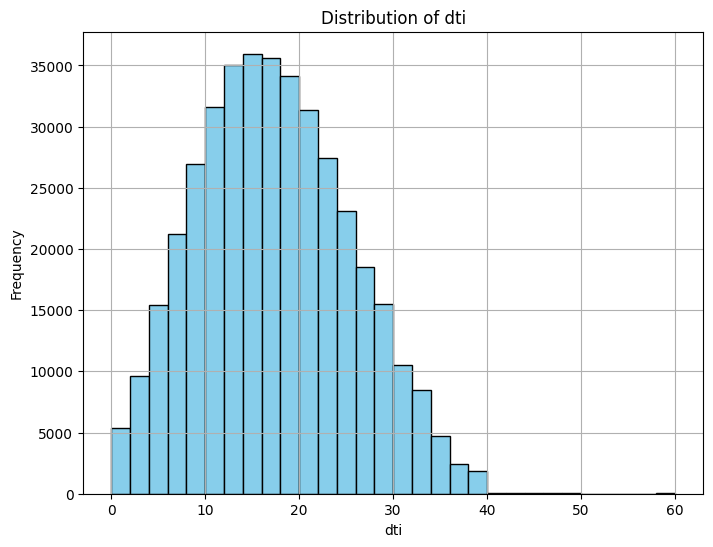

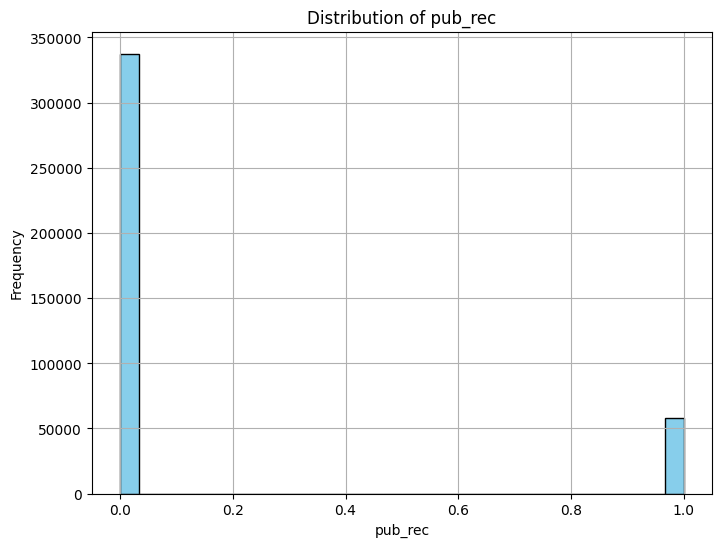

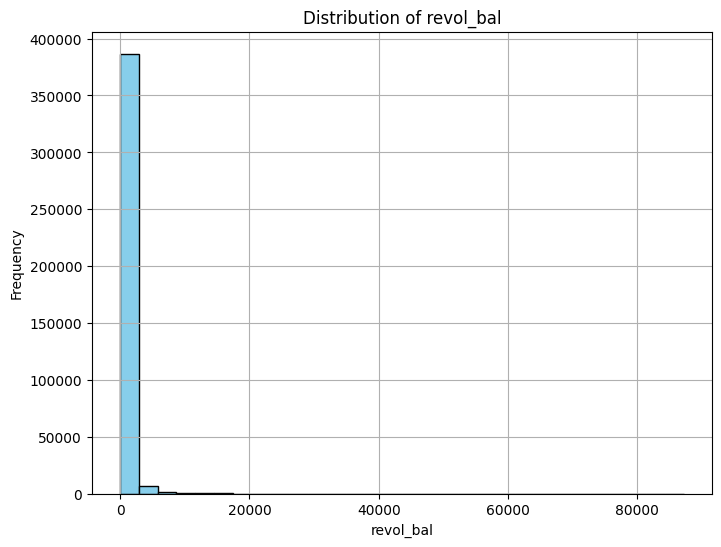

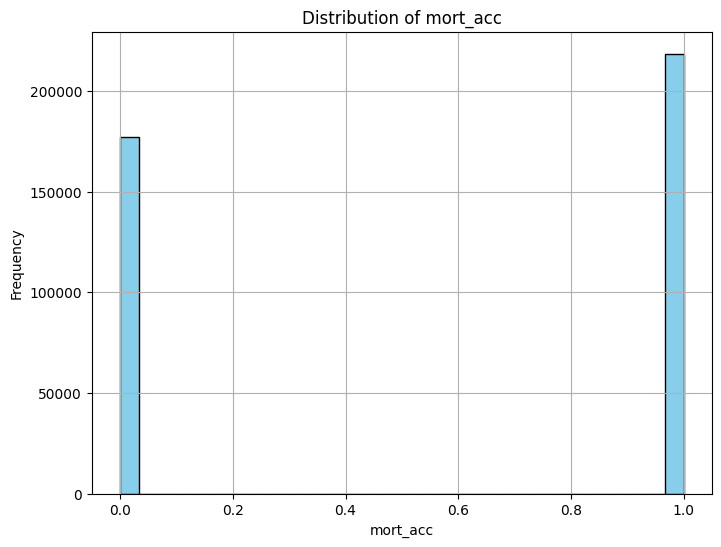

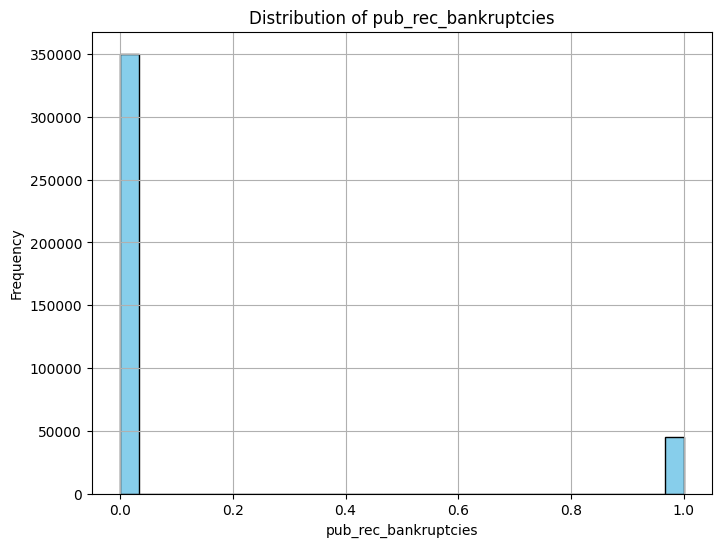

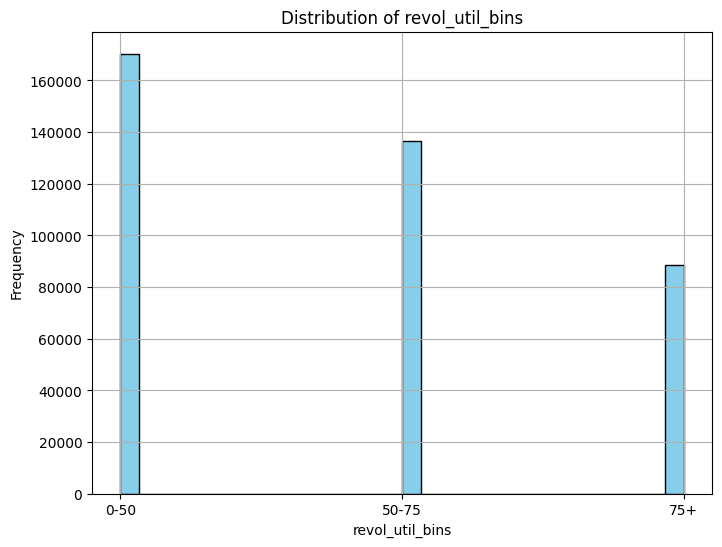

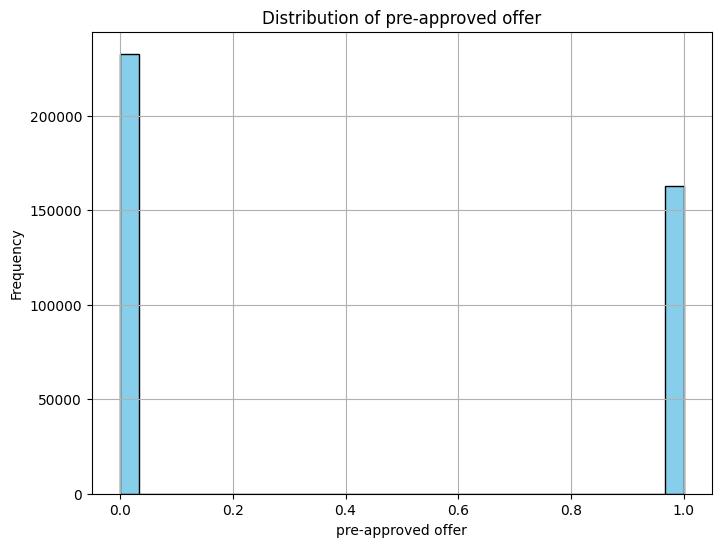

In [58]:
for column in neumrical_column :
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

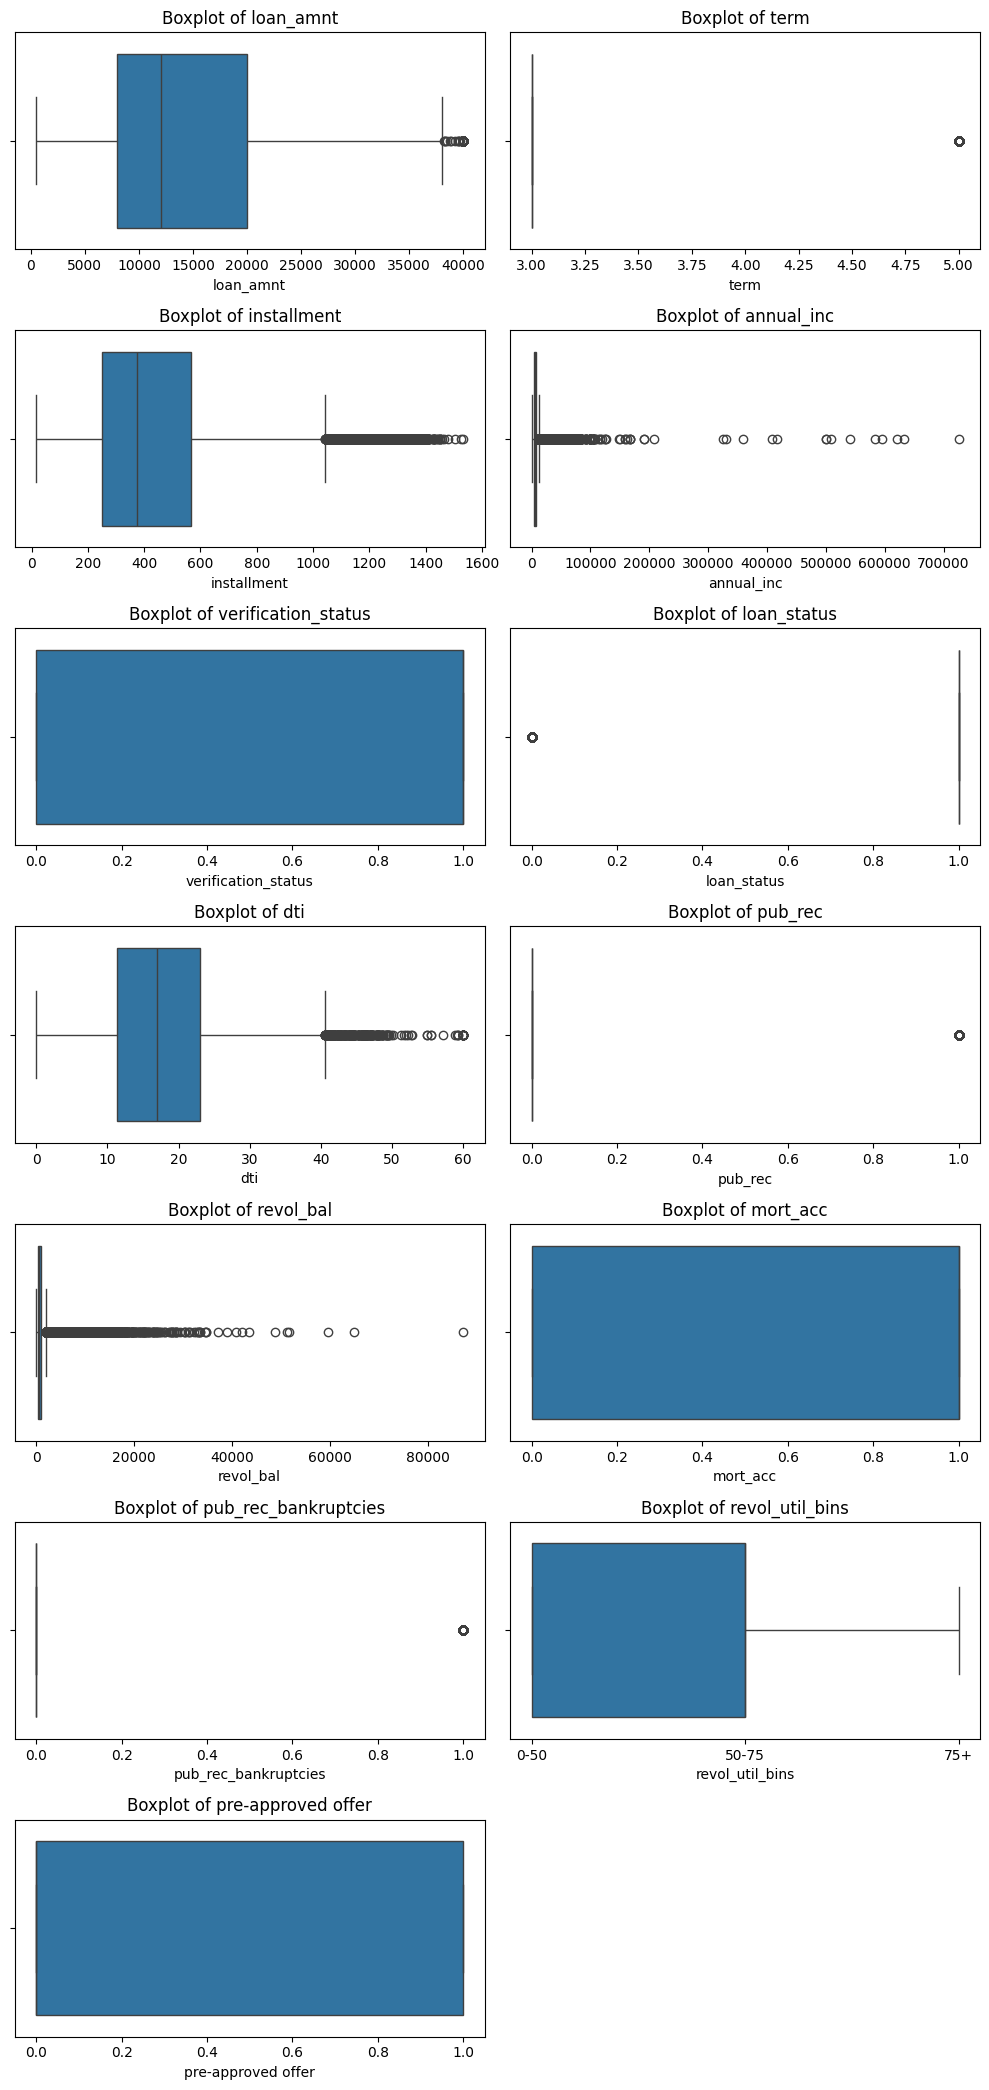

In [59]:
fig = plt.figure(figsize=(10,21))
i=1
for col in neumrical_column:
  ax = plt.subplot(7,2,i)
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col}')
  i += 1

plt.tight_layout()
plt.show()

### MODEL BUILDING

In [60]:
df.head()

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,mort_acc,pub_rec_bankruptcies,pincode,revol_util_bins,pre-approved offer
0,10000.0,3,329.48,b,rent,9750.0,0,1,26.24,0,1819.0,0,0,22690,0-50,1
1,8000.0,3,265.68,b,mortgage,5417.0,0,1,22.05,0,1007.0,1,0,05113,50-75,1
2,15600.0,3,506.97,b,rent,3589.0,1,1,12.79,0,600.0,0,0,05113,75+,0


In [61]:
df['home_ownership'].value_counts()

home_ownership
mortgage    198151
rent        159508
own          37692
Name: count, dtype: int64

In [62]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['pre-approved offer'])  # Features
y = df['pre-approved offer']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
X_train.head(3)

,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,mort_acc,pub_rec_bankruptcies,pincode,revol_util_bins
349994,30000.0,5,747.84,d,own,7435.0,1,1,28.50,0,669.0,0,0,30723,0-50
311775,6300.0,3,238.95,d,mortgage,7100.0,1,1,11.38,1,0.0,1,1,05113,0-50
114106,20000.0,5,510.60,d,mortgage,6000.0,1,1,19.98,0,557.0,1,0,05113,50-75


In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline

# Define the order of categories for ordinal encoding
grade_categories = [['a', 'b', 'c', 'd', 'e', 'f', 'g']]
revol_util_bins_categories = [['0-50', '50-75', '75+']]
home_ownership_categories = [['own', 'mortgage', 'rent']]

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p), ['loan_amnt', 'installment', 'annual_inc', 'dti', 'revol_bal']),
        ('ordinal_grade', OrdinalEncoder(categories=grade_categories), ['grade']),
        ('ordinal_revol_util', OrdinalEncoder(categories=revol_util_bins_categories), ['revol_util_bins']),
        ('ordinal_home_ownership', OrdinalEncoder(categories=home_ownership_categories), ['home_ownership']),
        ('ohe', OneHotEncoder(), ['pincode'])
    ],
    remainder='passthrough'  # Pass through the remaining columns unchanged
)

# Apply transformations to the DataFrame
X_train_transformed = preprocessor.fit_transform(X_train)




In [65]:
X_train_transformed[0]

array([10.30898599,  6.61852534,  8.91408835,  3.38439026,  6.50727771,
        3.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  5.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  0.        ])

In [66]:
X_train_transformed.shape

(316280, 24)

In [67]:
X_test_transformed = preprocessor.transform(X_test)

In [68]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Define regularization strength for logistic regression and support vector classifier
logistic_regression_params = {'C': 0.1}  # Adjust C for regularization strength
svc_params = {'C': 1.0}  # Adjust C for regularization strength

# Define hyperparameters for decision tree, random forest, gradient boosting, k-neighbors, xgboost, catboost, and adaboost
# These hyperparameters control model complexity indirectly, affecting regularization
decision_tree_params = {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}
random_forest_params = {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}
gradient_boosting_params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
k_neighbors_params = {'n_neighbors': 5}
xgboost_params = {'max_depth': 3, 'learning_rate': 0.1}
catboost_params = {'iterations': 100, 'depth': 3, 'learning_rate': 0.1, 'silent': True}
adaboost_params = {'n_estimators': 50, 'learning_rate': 0.1}

# Define models with regularization or hyperparameters
models = {
    "Random Forest": RandomForestClassifier(**random_forest_params),
    "Decision Tree": DecisionTreeClassifier(**decision_tree_params),
    
    "Logistic Regression": LogisticRegression(**logistic_regression_params),
    
    "XGBClassifier": XGBClassifier(**xgboost_params),
    
    
}




In [70]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [71]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X_train_transformed,X_test_transformed,y_train,y_test ,models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
   
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train_transformed, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train_transformed)
        y_test_pred = model.predict(X_test_transformed)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

In [72]:
base_model_report = evaluate_models(X_train_transformed, X_test_transformed, y_train, y_test, models)

Random Forest
Model performance for Test set
- Accuracy: 0.9187
- F1 score: 0.9075
- Precision: 0.8516
- Recall: 0.9714
- Roc Auc Score: 0.9267


Decision Tree
Model performance for Test set
- Accuracy: 0.9029
- F1 score: 0.8869
- Precision: 0.8508
- Recall: 0.9262
- Roc Auc Score: 0.9064


Logistic Regression
Model performance for Test set
- Accuracy: 0.8972
- F1 score: 0.8755
- Precision: 0.8708
- Recall: 0.8803
- Roc Auc Score: 0.8946


XGBClassifier
Model performance for Test set
- Accuracy: 0.9683
- F1 score: 0.9624
- Precision: 0.9376
- Recall: 0.9885
- Roc Auc Score: 0.9713




### Hyperparameter Tuning

In [73]:
# Logistic Regression Parameters
logistic_regression_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Type of regularization penalty
    'solver': ['liblinear', 'saga']  # Optimization algorithm
}

# Decision Tree Parameters
decision_tree_params = {
    'max_depth': range(3, 10),  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Random Forest Parameters
rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

# XGBoost Parameters
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}


In [74]:
# Models list for Hyperparameter tuning
hyperparameter_tuning_models = [
    ('Logistic Regression', LogisticRegression(), logistic_regression_params),
    ('Decision Tree', DecisionTreeClassifier(), decision_tree_params),
    ('Random Forest', RandomForestClassifier(), rf_params),
    ('XGBoost', XGBClassifier(), xgboost_params)
]

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define XGBoost parameters for hyperparameter tuning
xgboost_params = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300]
}

# Initialize the model
xgboost_model = XGBClassifier()

# Perform Randomized Search
random = RandomizedSearchCV(estimator=xgboost_model,
                            param_distributions=xgboost_params,
                            n_iter=100,
                            cv=3,
                            verbose=2,
                            n_jobs=-1)

# Fit the model on the training data
random.fit(X_train_transformed, y_train)

# Get the best parameters
best_params = random.best_params_

print(f"---------------- Best Params for XGBoost -------------------")
print(best_params)


# Best models dictionary with the best parameters for XGBoost
best_models = {
    "XGBClassifier": XGBClassifier(**best_params, n_jobs=-1),
}

# Evaluate the best XGBoost model
tuned_report = evaluate_models(X_train_transformed, X_test_transformed, y_train, y_test, best_models)
print(tuned_report)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------------- Best Params for XGBoost -------------------
{'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.3}
XGBClassifier
Model performance for Test set
- Accuracy: 0.9947
- F1 score: 0.9935
- Precision: 0.9921
- Recall: 0.9949
- Roc Auc Score: 0.9947


      Model Name  Accuracy
0  XGBClassifier  0.994676
